In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf

2024-03-14 22:36:00.815951: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-14 22:36:00.967006: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 22:36:02.536500: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# For logging metrics to Weights and Biases Platform.
USING_WANDB = True  # Set to false if you don't have an account

if USING_WANDB:
    !pip install wandb &> /dev/null  # install wandb
    import wandb
    from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
    wandb.login()  # prompts for api key

^C


ModuleNotFoundError: No module named 'wandb'

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [3]:
# Unzip data zip file
# !rm -r project_data
!unzip project_data.zip &> /dev/null
!rm -r __MACOSX
!mv project/* .
!rm -r project
# &> /dev/null  to quiet output

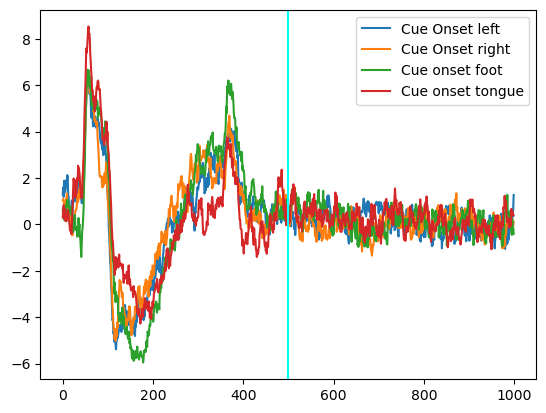

In [7]:
import numpy as np
path_prefix = "./project_data/project/"

X_test = np.load(path_prefix+"X_test.npy")
y_test = np.load(path_prefix+"y_test.npy")
person_train_valid = np.load(path_prefix+"person_train_valid.npy")
X_train_valid = np.load(path_prefix+"X_train_valid.npy")
y_train_valid = np.load(path_prefix+"y_train_valid.npy")
person_test = np.load(path_prefix+"person_test.npy")


## Adjusting the labels so that

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769




## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [3]:
def train_data_prep(X,y,sub_sample,average,noise, cutoff):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:cutoff]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    # Data augmentation: increases number of samples (max pool and mean pool +noise)
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


# Don't increase the number of test samples
def test_data_prep(X, cutoff):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:cutoff]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)


    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X

In [4]:
def preprocess(X_train_valid, y_train_valid, X_test, y_test, cutoff):
    num_train_valid = X_train_valid.shape[0]
    print(num_train_valid, " total train_val samples")

    valid_split = 0.2
    valid_count = int(num_train_valid * valid_split)

    # Train val split, then data augment the training set
    ind_valid = np.random.choice(X_train_valid.shape[0], valid_count, replace=False)

    ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
    # Creating the training and validation sets using the generated indices
    (x_train_unprocessed, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
    (y_train_unprocessed, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

    print("Augmenting train data")
    x_train, y_train = train_data_prep(x_train_unprocessed, y_train_unprocessed,2,2,True, cutoff)
    print("Augmenting val data")
    x_valid, y_valid = train_data_prep(x_valid, y_valid, 2, 2, True, cutoff)
    print("Augmenting test data")
    X_test_prep = test_data_prep(X_test, cutoff)


    # Old code with data leakage
    ## Preprocessing the dataset
    # X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
    # X_test_prep = test_data_prep(X_test)
    # ## Random splitting and reshaping the data
    # # First generating the training and validation indices using random splitting
    # # 8460 is shape of num_samples after data augmentation
    # ind_valid = np.random.choice(8460, 1000, replace=False)
    # ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))
    # # Creating the training and validation sets using the generated indices
    # (x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid]
    # (y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
    print('Shape of training set:',x_train.shape)
    print('Shape of validation set:',x_valid.shape)
    print('Shape of training labels:',y_train.shape)
    print('Shape of validation labels:',y_valid.shape)


    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(y_test, 4)
    print('Shape of training labels after categorical conversion:',y_train.shape)
    print('Shape of validation labels after categorical conversion:',y_valid.shape)
    print('Shape of test labels after categorical conversion:',y_test.shape)

    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
    print('Shape of training set after adding width info:',x_train.shape)
    print('Shape of validation set after adding width info:',x_valid.shape)
    print('Shape of test set after adding width info:',x_test.shape)


    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)
    print('Shape of training set after dimension reshaping:',x_train.shape)
    print('Shape of validation set after dimension reshaping:',x_valid.shape)
    print('Shape of test set after dimension reshaping:',x_test.shape)
    # Note the dims of validation are diff than originally bc no longer data augment it

    return x_train, y_train, x_valid, y_valid, x_test, y_test


In [8]:

def get_data(cutoff):
    """Returns split and preprocessed data for both subject train and test (subject and rest)"""
    x_sub_train_val = X_train_valid
    y_sub_train_val = y_train_valid
    x_sub_test = X_test
    y_sub_test = y_test

    return preprocess(x_sub_train_val, y_sub_train_val, x_sub_test, y_sub_test, cutoff)


In [10]:
a,b,c,d,e,f = get_data(1000)
print(a.shape)
print(b.shape)
print(c.shape)
print(d.shape)
print(e.shape)
print(f.shape)

2115  total train_val samples
Augmenting train data
Shape of X after trimming: (1692, 22, 1000)
Shape of X after maxpooling: (1692, 22, 500)
Shape of X after averaging+noise and concatenating: (3384, 22, 500)
Shape of X after subsampling and concatenating: (6768, 22, 500)
Shape of Y: (6768,)
Augmenting val data
Shape of X after trimming: (423, 22, 1000)
Shape of X after maxpooling: (423, 22, 500)
Shape of X after averaging+noise and concatenating: (846, 22, 500)
Shape of X after subsampling and concatenating: (1692, 22, 500)
Shape of Y: (1692,)
Augmenting test data
Shape of X after trimming: (443, 22, 1000)
Shape of X after maxpooling: (443, 22, 500)
Shape of training set: (6768, 22, 500)
Shape of validation set: (1692, 22, 500)
Shape of training labels: (6768,)
Shape of validation labels: (1692,)
Shape of training labels after categorical conversion: (6768, 4)
Shape of validation labels after categorical conversion: (1692, 4)
Shape of test labels after categorical conversion: (443, 4)

## Train model with different cutoffs each time


In [ ]:
# Try isolating each subject

lr = 1e-3
NUM_EPOCHS = 100
batch_size = 64
patience = 5  # 3
callbacks = []
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience))
criterion="categorical_crossentropy"
optimizer = keras.optimizers.Adam(learning_rate=lr)

cutoff_test_accs = []
for cutoff in range(100,1000,50):
    print(f"Training on subject {i} (0-index)")
    x_sub_train, y_sub_train, x_sub_valid, y_sub_valid, x_sub_test, y_sub_test= get_data(cutoff)

    # TODO Insert model here
    model =

    model.compile(loss=criterion, optimizer=optimizer, metrics=['accuracy'])

    # Training and validating the model
    model_results = model.fit(x_sub_train, y_sub_train,
                batch_size=batch_size,
                epochs=NUM_EPOCHS, callbacks=callbacks,
                validation_data=(x_sub_valid, y_sub_valid), verbose=1)  #, verbose=True)

    test_sub_acc = model.evaluate(x_sub_test, y_sub_test, verbose=0)
    cutoff_test_accs.append(test_sub_acc)
    # model_score = model.evaluate(x_sub_test, y_sub_test, verbose=0)
    # test_acc = model_score[1]
    print(f'Test acc of the subject : {test_sub_acc : .4f}')

In [ ]:
import matplotlib.pyplot as plt

# TODO TRY BAR instead

plt.figure()
plt.plot(range(len(cutoff_test_accs)), cutoff_test_accs)
plt.xlabel(f'Subject')
plt.ylabel(f'Test Acc (subject)')
plt.title("Test Acc of Cutoff ")


In [8]:
# print(f"{x_train.shape[0]} train samples")
# print(f"{x_valid.shape[0]} valid samples")
# print(f"{X_test.shape[0]} test samples")

6768 train samples
1692 valid samples
443 test samples


Train on only subject_1 data

Evaluate on rest of the subjects